## SF Crime Prediction Data Science 

#### Importing the libraries and relevant system settings

In [2]:
# Importing the libraries
import pandas as pd
import pandasql as ps
import re 
import os
import copy 
import numpy as np
from IPython.display import display
import sklearn 
import pickle
import cPickle
import nltk
import scipy as sp
%matplotlib inline  
# Don't use plt.show() as it opens a new window and blocks the evaluation of cell. 
import matplotlib.pyplot as plt
# Changing the default data frame options. 
pd.set_option("max_r",300000) # Set the default rows to 3000
pd.set_option("max_columns",51000) # Set the default columns to 500 from 20. 
pd.set_option("expand_frame_repr",False) # Checks if frame can be expanded or truncated. Make it expand column-wise
pd.set_option("max_colwidth",500) # Set the width of column from 50 to 500
np.set_printoptions(threshold=np.inf) # Removes the threshold level to print numpy array
np.set_printoptions(suppress=True) # Prevent printing in scientific notation

##  Machine Learning- Predicting Crime Category 

In [147]:
# Reading the csv data into Python pandas dataframe. 

df=pd.read_csv('data_set.csv')

#### Printing the first 5 rows and checking the dimensions of the data

In [148]:
print "The dimension of the dataset is : ", df.shape, df.dtypes
df.head()

The dimension of the dataset is :  (74760, 7) Dates          object
Category       object
Descript       object
PdDistrict     object
Address        object
X             float64
Y             float64
dtype: object


,Dates,Category,Descript,PdDistrict,Address,X,Y
0,2014-12-28 23:30:00,LARCENY/THEFT,GRAND THEFT PICKPOCKET,MISSION,4100 Block of 18TH ST,-122.435563,37.760801
1,2014-12-28 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NaN,NaN,NaN,NaN
2,2014-12-28 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,CENTRAL,500 Block of GEARY ST,-122.412777,37.786834
3,2014-12-28 23:30:00,ASSAULT,AGGRAVATED ASSAULT WITH A DEADLY WEAPON,NORTHERN,0 Block of ROSE ST,-122.421702,37.773641
4,2014-12-28 23:30:00,ASSAULT,INFLICT INJURY ON COHABITEE,NORTHERN,0 Block of ROSE ST,-122.421702,37.773641


#### Lets check the time frame of the data

In [149]:
# Using sql on pandas dataframe using pandasql

pysqldf = lambda q: ps.sqldf(q, globals())

sql="""
select min(Dates) , max(Dates)
from df 
"""

print "The first and last recorded date is:", pysqldf(sql)

The first and last recorded date is:             min(Dates)           max(Dates)
0  2014-01-06 00:01:00  2014-12-28 23:30:00


#### So the dataset spans from start of 2014 to end of 2014. 

In [189]:
#### Converting the Datetime field to datetime data type
df['Dates']=pd.to_datetime(df.Dates)
df['Category'] = df['Category'].astype('category')

print df.Dates.dtype, df.Category.dtype

datetime64[ns] category


### On careful examination of data we see that wherever all values of PdDistrict which is Missing, corresponding Address and Lat/Long is also missing  
So its better to drop all observations where PdDistrict is missing


In [150]:
# Dropping observations where PdDistrict is NAN

df=df[df.PdDistrict.notnull()]
df.shape

(71160, 7)

#### Checking the total unique categories of Crime

In [151]:
df.Category.value_counts()

LARCENY/THEFT                  18053
OTHER OFFENSES                  9787
NON-CRIMINAL                    9185
ASSAULT                         5939
VEHICLE THEFT                   3389
VANDALISM                       3354
WARRANTS                        3271
BURGLARY                        2863
DRUG/NARCOTIC                   2615
SUSPICIOUS OCC                  2476
MISSING PERSON                  2171
ROBBERY                         1682
FRAUD                           1419
SECONDARY CODES                  864
WEAPON LAWS                      743
TRESPASS                         554
STOLEN PROPERTY                  486
SEX OFFENSES FORCIBLE            381
FORGERY/COUNTERFEITING           354
DRUNKENNESS                      290
KIDNAPPING                       249
PROSTITUTION                     183
DRIVING UNDER THE INFLUENCE      177
DISORDERLY CONDUCT               161
ARSON                            110
RUNAWAY                          107
LIQUOR LAWS                       77
E

#### i) Plotting the distribution of the categories

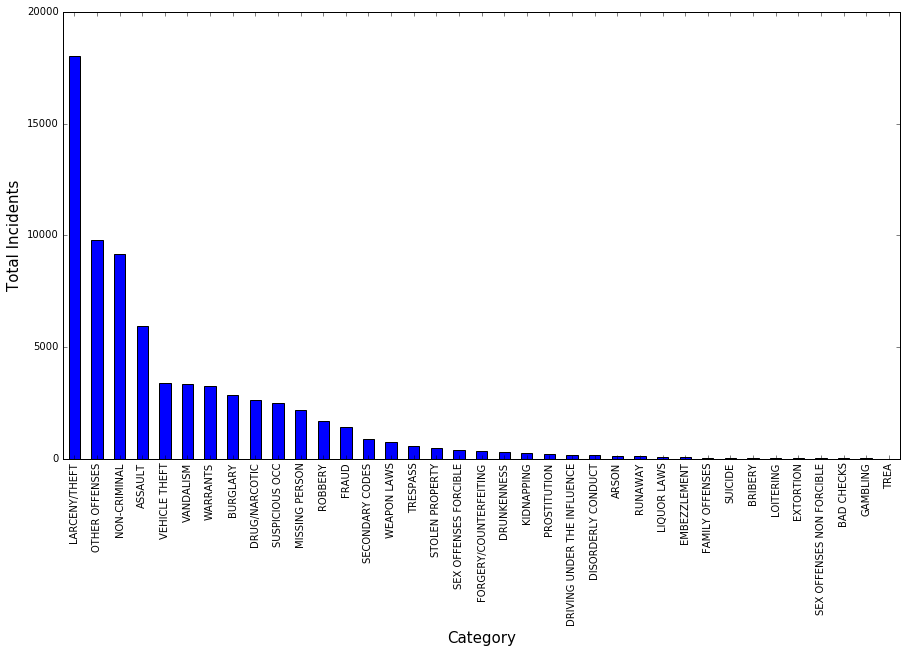

In [140]:
# Plotting the IsDriving distribution
fig=plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
df1=df.Category.value_counts()
df1.plot.bar()
plt.xlabel("Category",fontsize=15)
plt.ylabel("Total Incidents",fontsize=15)

#### As we see, most of the crimes close to 68% occur in top 5-6 categories of crime. It's a long tail distribution data

#### ii) Visualizing the data by Pd District

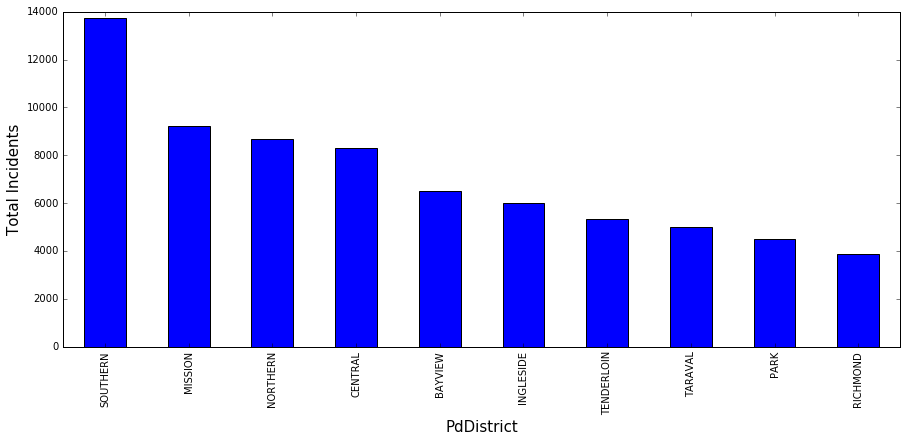

In [141]:
# Plotting the IsDriving distribution
fig=plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
df1=df.PdDistrict.value_counts()
df1.plot.bar()
plt.xlabel("PdDistrict",fontsize=15)
plt.ylabel("Total Incidents",fontsize=15)

#### Maximum no. of incidents have occured in the Southern and Mission district. This PdDistrict could be a useful feature for prediction

#### iii) Grouping crime categories by PdDistrict of the year

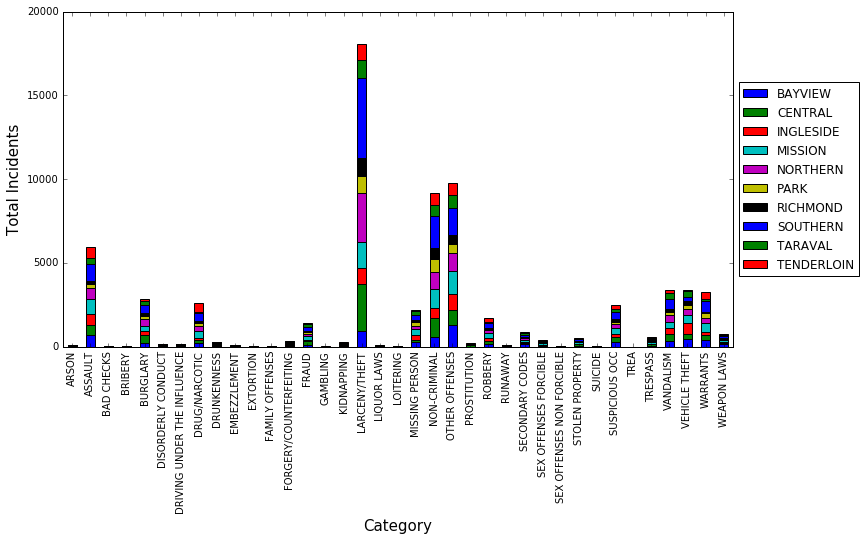

In [190]:
fig=plt.figure(figsize=(17,10))
df2 = df.groupby(['Category', 'PdDistrict'])['Category'].count().unstack('PdDistrict').fillna(0)
df2.plot(kind='bar', stacked=True,figsize=(12,6))
plt.xlabel("Category",fontsize=15)
plt.ylabel("Total Incidents",fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

#### iv) Visualizing Top Crimes categories by Day of Week

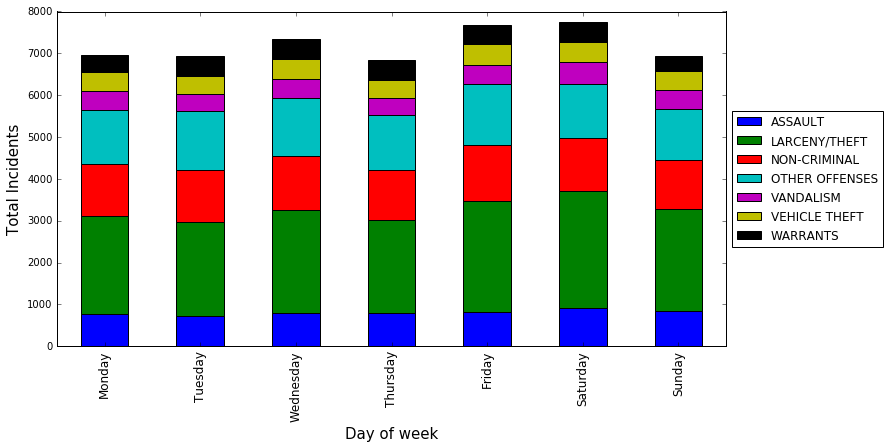

In [188]:
# Filtering for Top Crime Categories
df1=df[df.Category.isin(['LARCENY/THEFT','OTHER OFFENSES','NON-CRIMINAL','ASSAULT',
                         'VEHICLE THEFT','VANDALISM','WARRANTS'])]
plt.figure(figsize=(18,11))
dow=pd.to_datetime(df1['Dates']).dt.dayofweek
x=[0,1,2,3,4,5,6]
Weekdays= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df2 = df1.groupby([dow,'Category'])['Category'].count().unstack('Category').fillna(0)
df2.plot(kind='bar', stacked=True,figsize=(12,6))
plt.xlabel("Day of week",fontsize=15)
plt.ylabel("Total Incidents",fontsize=15)
plt.xticks(x,Weekdays,fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### Feature Engineering- Creating few time features from existing variables  

##### Avg. No. of days (time elapsed) for different category of crimes could be a potential feature. However due to interest of time I did not calculate those features

i)  **First predicting all classes**   
ii) **Then grouping the classes by keeping top 9 and remaining as 'Others'**

In [111]:
Top_cat=['LARCENY/THEFT','OTHER OFFENSES','NON-CRIMINAL','ASSAULT','VEHICLE THEFT',
         'VANDALISM','WARRANTS','BURGLARY','DRUG/NARCOTIC']
df['Category_grouped'] = np.where(~df['Category'].isin(Top_cat),'Others',df.Category)
df['Category_grouped']=df.Category_grouped.astype('category')

In [112]:
# Recoding the Category Catgorical variable to numeric categores

#df['Crime_class']=df.Category.cat.codes
df['Crime_class']=df.Category_grouped.cat.codes


# Creating a dictionary of mapping of actual string to numeric codes
#class_mapping = dict(zip(df.Category, df.Crime_class))
class_mapping = dict(zip(df.Category_grouped, df.Crime_class))


# Creating day of week features as binary features

df['IsMonday']=np.where(df['Dates'].dt.dayofweek==0.0,1,0)
df['IsTuesday']=np.where(df['Dates'].dt.dayofweek==1.0,1,0)
df['IsWednesday']=np.where(df['Dates'].dt.dayofweek==2.0,1,0)
df['IsThursday']=np.where(df['Dates'].dt.dayofweek==3.0,1,0)
df['IsFriday']=np.where(df['Dates'].dt.dayofweek==4.0,1,0)
df['IsSaturday']=np.where(df['Dates'].dt.dayofweek==5.0,1,0)

# Creating hour the day features
df['HrofDay_0_6']=np.where(df['Dates'].dt.hour.isin([0,1,2,3,4,5,6]),1,0)
df['HrofDay_6_12']=np.where(df['Dates'].dt.hour.isin([7,8,9,10,11,12]),1,0)
df['HrofDay_12_18']=np.where(df['Dates'].dt.hour.isin([13,14,15,16,17,18]),1,0)
df['HrofDay_18_00']=np.where(df['Dates'].dt.hour.isin([19,20,21,22,23]),1,0)

# Binarising PdDistrict to n-1 dummies

df['IsSouthern']=np.where(df['PdDistrict']=='SOUTHERN',1,0)
df['IsMission']=np.where(df['PdDistrict']=='MISSION',1,0)
df['IsNorthern']=np.where(df['PdDistrict']=='NORTHERN',1,0)
df['IsCentral']=np.where(df['PdDistrict']=='CENTRAL',1,0)
df['IsBayView']=np.where(df['PdDistrict']=='BAYVIEW',1,0)
df['IsIngleside']=np.where(df['PdDistrict']=='INGLESIDE',1,0)
df['IsTenderloin']=np.where(df['PdDistrict']=='TENDERLOIN',1,0)
df['IsTaraval']=np.where(df['PdDistrict']=='TARAVAL',1,0)



Few other Important Features to consider

#### There are few more features which could be created. Not doing due to interest of time. Few suggestins : 
1) **Time elapsed between same incident category**   
2) **Grouping Lat/Long to clusters of neighbourhood location instead of directly using the values**  
3) **Creating features out of different Streets mentoned in the address field**  
4) **Week of the month from the timestamp field**  
5) ** Count of crime before the current crime in a crime category**


In [113]:
print 'Category Mapping is:'
class_mapping

Category Mapping is:


{'ASSAULT': 0,
 'BURGLARY': 1,
 'DRUG/NARCOTIC': 2,
 'LARCENY/THEFT': 3,
 'NON-CRIMINAL': 4,
 'OTHER OFFENSES': 5,
 'Others': 6,
 'VANDALISM': 7,
 'VEHICLE THEFT': 8,
 'WARRANTS': 9}

#### Dropping the existing date and id columns

In [114]:
#cols=['Dates','Category','Descript','Address']

# For top ten categories 
cols=['Dates','Category','Category_grouped','Descript','Address']

df=df.drop(cols,axis=1)

In [115]:
df.head()

,PdDistrict,X,Y,Crime_class,IsMonday,IsTuesday,IsWednesday,IsThursday,IsFriday,IsSaturday,HrofDay_0_6,HrofDay_6_12,HrofDay_12_18,HrofDay_18_00,IsSouthern,IsMission,IsNorthern,IsCentral,IsBayView,IsIngleside,IsTenderloin,IsTaraval
0,MISSION,-122.435563,37.760801,3,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2,CENTRAL,-122.412777,37.786834,8,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,NORTHERN,-122.421702,37.773641,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,NORTHERN,-122.421702,37.773641,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
6,NORTHERN,-122.421702,37.773641,9,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0


### Functions for Data Cleaning & Wrangling

In [116]:

def varWithMissingValue(model_data1): 
    """ This function looks at the model data 
    and does missing value treatment of the features
    
    """
    
    NMissing=(model_data1.describe().ix[0])/len(model_data1)*100
    NMissing.sort(ascending=False)
    
    # Getting the list of variables less than 65% full
    highmissing_vars=NMissing[NMissing<=60]
    print "Missing value distribution:\n\n", NMissing
    
    print "\n\nFeatures which are least populated:\n\n",highmissing_vars
    
    # Checking the variances of each feature and getting a list of features with values less than equal to zero
    std=(model_data1.describe().ix[2])
    zerostd_vars=std[std<=0]
    print "\n\nFeatures with zero variance:\n\n", zerostd_vars
    
    return highmissing_vars,zerostd_vars



def missingValueTreatment(model_data1):
    """ Doing the missing value treatment for features
    
    Convert the NA in Lat/Long to Median of Corresponding PdDistrict values. 
    
    This is one basic approach. 
    
    Other approach could be do Expectation-Maximization (EM)
    alog and fill the missing value
    
    """
    
    
    # Filling the missing value of Lat/Long with Median of the Corresponding PdDistrict values
    
    model_data1['X'] = model_data1.groupby('PdDistrict').transform(lambda x: x.fillna(x.median()))
    model_data1['Y'] = model_data1.groupby('PdDistrict').transform(lambda x: x.fillna(x.median()))
    

    # Re-running missing value check 
    # Finding the % non Missing in each variable-- SHOULD GIVE ZERO FEATURES NOW
    NMissing=(model_data1.describe().ix[0])/len(model_data1)*100
    print "\n\nFeatures with missing values: \n\n", NMissing[NMissing<100]
    
    return model_data1
    
    
def dropVars(model_data1,zerostd_vars,highmissing_vars, Extra_var):
    """Dropping the variables which are not important
    
    """
    
    # List of features to be dropped
    
    to_be_dropped=list(set(list(zerostd_vars.index)+Extra_var+list(highmissing_vars.index)))
    print "\n\nFeatures to be dropped:\n\n", to_be_dropped
    
    # Dropping the list of variables
    
    print "\n\nList of features to be dropped:\n\n",to_be_dropped
    model_data1=model_data1.drop(to_be_dropped,axis=1)
    
    ## Rechecking the data again for features with zero variance. Should get zero
    checkstd=(model_data1.describe().ix[2])
    print "\n\nFeatures with zero variance:\n\n", checkstd[checkstd<=0]
    
    return model_data1

    
def featuresDtypes(model_data1):
    """This function takes a dataframe and gives a dict of column
    data types
    
    """
    
    g = model_data1.columns.to_series().groupby(model_data1.dtypes).groups
    var_types={k.name: v for k, v in g.items()}
    
    return var_types


def featureStd(model_data_transformed,var_types):
    """This function standardizes the features which have std of more than 1
    
    """
    
    data=copy.deepcopy(model_data_transformed)
    continuous_var=var_types['float64']
    Features_with_morethan1_std=data[continuous_var].describe().ix[2][data[continuous_var].describe().ix[2]>1]
    print "Features with more than 1 s.d\n\n",Features_with_morethan1_std
    
    # Standardising the above list of features 

    high_std_features=list(Features_with_morethan1_std.index)
    # Standardising the above list of features with zero mean and unit std. 

    for x in high_std_features:
        data[x]=((data[x]-data[x].mean())/data[x].std()).round(decimals=4)
        # Normalising
        #data[x]=((data[x]-data[x].mean())/(data[x].max()-data[x].min())).round(decimals=4)
    
    # Rechecking the std and mean of above features 
    print "Rechecking the sd of feature: \n\n", data[high_std_features].describe().ix[2],data[high_std_features].describe().ix[1]
    
    return data, continuous_var,high_std_features
    
    
    
def createModelVectors(model_data2,dependent_var):
    """This function takes in a model data 
    and separates the design matrix from the Target Vector
    
    """
    
    from sklearn.preprocessing import label_binarize
    # Separating the training data X from Label Y
    Y=model_data2[dependent_var].values
    Y=label_binarize(Y, classes=range(len(class_mapping)))
    X=model_data2.drop([dependent_var],axis=1)
    
    X['Intercept']=1

    return X,Y


### Running Data Wrangling functions

In [117]:
model_data1=copy.deepcopy(df)
highmissing_vars,zerostd_vars=varWithMissingValue(model_data1)

/Users/i854319/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


Missing value distribution:

IsTaraval        100.0
HrofDay_0_6      100.0
Y                100.0
Crime_class      100.0
IsMonday         100.0
IsTuesday        100.0
IsWednesday      100.0
IsThursday       100.0
IsFriday         100.0
IsSaturday       100.0
HrofDay_6_12     100.0
IsTenderloin     100.0
HrofDay_12_18    100.0
HrofDay_18_00    100.0
IsSouthern       100.0
IsMission        100.0
IsNorthern       100.0
IsCentral        100.0
IsBayView        100.0
IsIngleside      100.0
X                100.0
Name: count, dtype: float64


Features which are least populated:

Series([], Name: count, dtype: float64)


Features with zero variance:

Series([], Name: std, dtype: float64)


### Doing Missing value treatment, Standardization of variables and Creating Model Vectors

In [118]:
# After dropping the observations corresponding to Pddistrict NA there is no missing values left

model_data1=missingValueTreatment(model_data1)

### Dropping the missing values and other variables
Extra_var=['PdDistrict']
model_data1=dropVars(model_data1,zerostd_vars,highmissing_vars,Extra_var)

# Getting a list of features with their types

var_types=featuresDtypes(model_data1)

# Features Standardizing - Only X and Y to be standardised
#model_data2,continuous_var,high_std=featureStd(model_data1,var_types)

# Separating the X and Y vector
X,Y=createModelVectors(model_data1,'Crime_class')



Features with missing values: 

Series([], Name: count, dtype: float64)


Features to be dropped:

['PdDistrict']


List of features to be dropped:

['PdDistrict']


Features with zero variance:

Series([], Name: std, dtype: float64)


In [119]:
# Functions for model 

# Spitting the dataset into train and test. 

# Training and test split


def split(X,Y):
    """This function samples the dataset into training and testing"""
    # Splitting into training and test. 
    from sklearn.cross_validation import train_test_split
    train_X, test_X,train_Y,test_Y = train_test_split(X, Y, test_size=0.30, random_state=42)
    
    return train_X, test_X,train_Y,test_Y


# Finding the k folds for training data


def kFold(train_X):
        '''This fucntion splits the training set into k folds
        '''
        from sklearn import cross_validation
        k_fold=cross_validation.KFold(n=train_X.shape[0],n_folds=5)
        
        return k_fold



# Didn't use it but ideally for parameter tuning one should do Grid Search

def gridSearch(train_X,train_Y):
    """THis function does the grid search
    
    """
    
    from sklearn import grid_search
    from sklearn.linear_model import LogisticRegression
    from sklearn.linear_model import SGDClassifier
    sgd=SGDClassifier(loss='log',class_weight={1:7})
    parameters = {'penalty':('elasticnet', 'l1'),'alpha':np.logspace(-3, 2, 10),
                  'l1_ratio':[0.15,0.25,0.35,0.40,0.50,0.60]}
    est = grid_search.GridSearchCV(sgd,parameters,cv=5)
    est.fit(train_X,train_Y)
    return est,est.grid_scores_ ,est.best_score_ , est.best_params_ 

    

    
def GNB(k_fold,train_X,train_Y):
        """Method to implement Multi-class Gaussian Naive Bayes"""
        
        from sklearn.naive_bayes import MultinomialNB
        scores_gnb = []
        
        for train_indices, test_indices in k_fold:
            train_X_cv = train_X[train_indices]
            train_Y_cv=  train_Y[train_indices]
 
            test_X_cv = train_X[test_indices]
            test_Y_cv=  train_Y[test_indices]
        
            gnb=MultinomialNB()
            scores_gnb.append(gnb.fit(train_X_cv,train_Y_cv).score(test_X_cv,test_Y_cv))
            
        print("The mean accuracy of GaussianNaive Bayes on CV data is:", np.mean(scores_gnb))    
        
        return gnb
    
    
    
    
def RF(k_fold,train_X,train_Y):
        """Method to implement Multi-class RandomForest"""
        
        from sklearn.ensemble import RandomForestClassifier
        scores_rf = []
        
        for train_indices, test_indices in k_fold:
            train_X_cv = train_X[train_indices]
            train_Y_cv= train_Y[train_indices]
 
            test_X_cv = train_X[test_indices]
            test_Y_cv= train_Y[test_indices]
        
            rf=RandomForestClassifier(n_estimators=150,criterion='entropy')
            scores_rf.append(rf.fit(train_X_cv,train_Y_cv).score(test_X_cv,test_Y_cv))

        print("The mean accuracy of Random Forests on CV data is:", np.mean(scores_rf))
        
        return rf

    
    
    
# Function for Multi-class SVM SVM
def SVM(k_fold,train_X,train_Y):
        """Method to implement Multi-class SVM using 
        One Vs Rest Classifier
        """
        
        from sklearn.ensemble import AdaBoostClassifier
        from sklearn.multiclass import OneVsRestClassifier
        
        scores_svm = []
        
        for train_indices, test_indices in k_fold:
            train_X_cv = train_X[train_indices]
            train_Y_cv= train_Y[train_indices]
 
            test_X_cv = train_X[test_indices]
            test_Y_cv= train_Y[test_indices]
        
            svm=OneVsRestClassifier(AdaBoostClassifier(n_estimators=100))
            scores_svm.append(svm.fit(train_X_cv,train_Y_cv).score(test_X_cv,test_Y_cv))

        print("The mean accuracy of Stochastic Gradient Descent SVM on CV data is:", np.mean(scores_svm)) 
        
        return svm
    
    
    
# Funciton for Multi class Logistic Regression 

def Multinomial_Logistic(k_fold,train_X,train_Y):
        """Method to implement Logistic Regression with Elastic net Regularization 
        """
        
        from sklearn.linear_model import LogisticRegression
        scores_lr = []
        
        for train_indices, test_indices in k_fold:
            train_X_cv = train_X[train_indices]
            train_Y_cv= train_Y[train_indices]
 
            test_X_cv = train_X[test_indices]
            test_Y_cv= train_Y[test_indices]
        
            lr=LogisticRegression(C=0.55,multi_class='ovr')
            scores_lr.append(lr.fit(train_X_cv,train_Y_cv).score(test_X_cv,test_Y_cv))

        print("The mean accuracy of Stochastic Gradient Descent Logistic on CV data is:", np.mean(scores_lr)) 
        
        return lr
        


def test_performance(test_X,test_Y,classifier,name):
        """This method checks the performance of each algorithm on test data."""
        
        from sklearn import metrics
        
        # For SGD
        print ("The accuracy of "+ name + " on test data is:",classifier.score(test_X,test_Y))
        print ('Classification Metrics for '+ name+ ' :')
        print metrics.classification_report(test_Y, classifier.predict(test_X))
        print "Confusion matrix"
        print metrics.confusion_matrix(test_Y, classifier.predict(test_X))        
        
        
        
def plot_ROC(test_X,test_Y,classifier,name):
    """ This functions plots the ROC curve of the classifier"""
    
    fig=plt.figure(figsize=(15,9))

    from sklearn.metrics import roc_curve, auc
    if name in ['rf','sgd_svm']:
        Y_score=classifier.predict_proba(test_X)
    else:
        Y_score = classifier.decision_function(test_X)


    n_classes = len(class_mapping)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_Y[:, i], Y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test_Y.ravel(), Y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    ##############################################################################
    # Plot ROC curves for the multiclass problem

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(15,11))

    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='AUC class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve of '+name)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    
    
def coefMatrix(X,classifier,name):
    """This function gets the coefficient matrix of the classifier"""
    
    features=list(X.columns)
    
    coef_matrix=pd.Series(list(classifier.coef_.T),index=features)
    
    print "\n\nThe Non Zero Weights for"+name+":\n\n",  coef_matrix[coef_matrix.abs()>0]
    return coef_matrix[coef_matrix.abs()>0]
    
    

### Setting up the ML pipeline

In [120]:
# Splitting the train and test. 
X_pr=X.values
train_X, test_X, train_Y, test_Y=split(X_pr,Y)
# Running k fold
k_fold=kFold(train_X)

In [121]:
# Printing the folds. 

for a,b in k_fold:
    print len(a), len(b)

39849 9963
39849 9963
39850 9962
39850 9962
39850 9962


#### Running Multi-Class SVM on all 37 classes


ROC Curve for Multi-Class SVM:




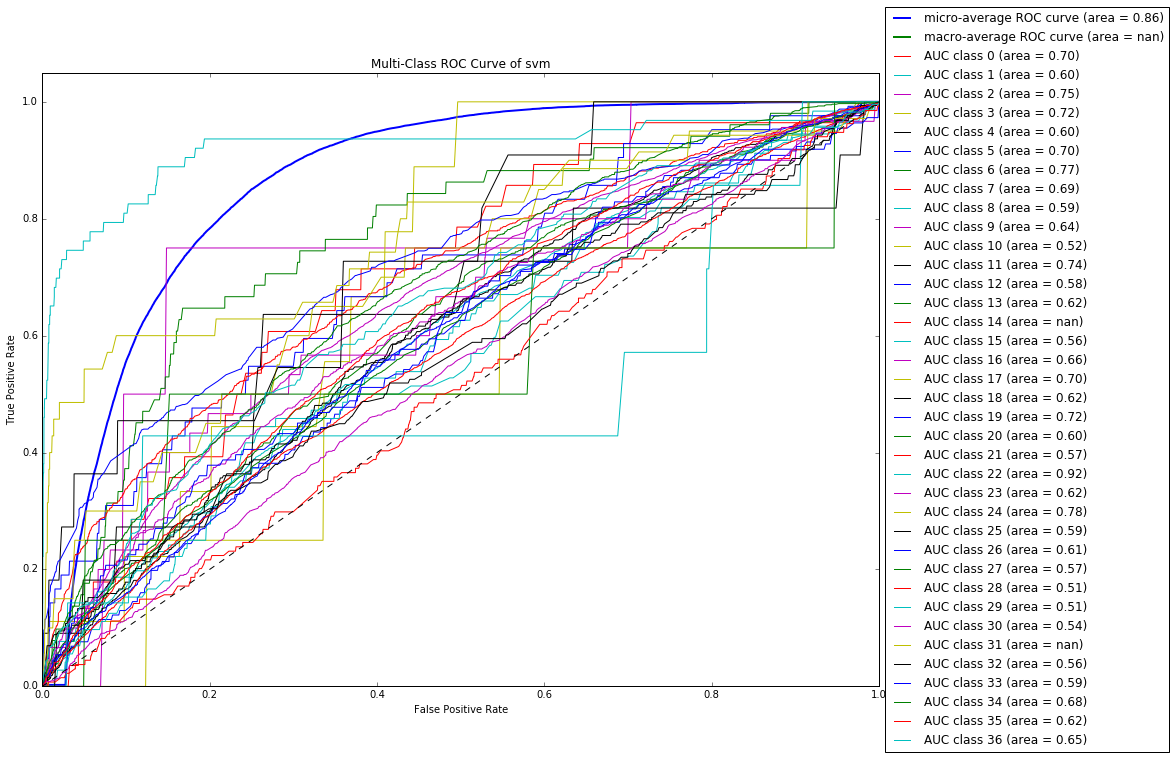

In [103]:
# Running SGD. and RF

svm=SVM(k_fold,train_X,train_Y)
#rf=RF(k_fold,train_X,train_Y)
#lr=Multinomial_Logistic(k_fold,train_X,train_Y)
#gnb=GNB(k_fold,train_X,train_Y)


# ROC Curves
print "ROC Curve for Multi-Class SVM:\n\n"
plot_ROC(test_X,test_Y,svm,"svm")

#print "ROC Curve for Gaussian Naive Bayes:\n\n"
#plot_ROC(test_X,test_Y,gnb,"Gaussian_NB")

#print "ROC Curve for Random Forests:\n\n"
#plot_ROC(test_X,test_Y,rf,"rf")

#print "ROC Curve for Logistic Regression:\n\n"
#plot_ROC(test_X,test_Y,lr,"lr")


#### Plotting ROC Curve and Predicting for Top Ten grouped class categories instead of all 37

('The mean accuracy of Stochastic Gradient Descent SVM on CV data is:', 0.0038344262851047169)
ROC Curve for Top 10 category Multi-Class SVM:




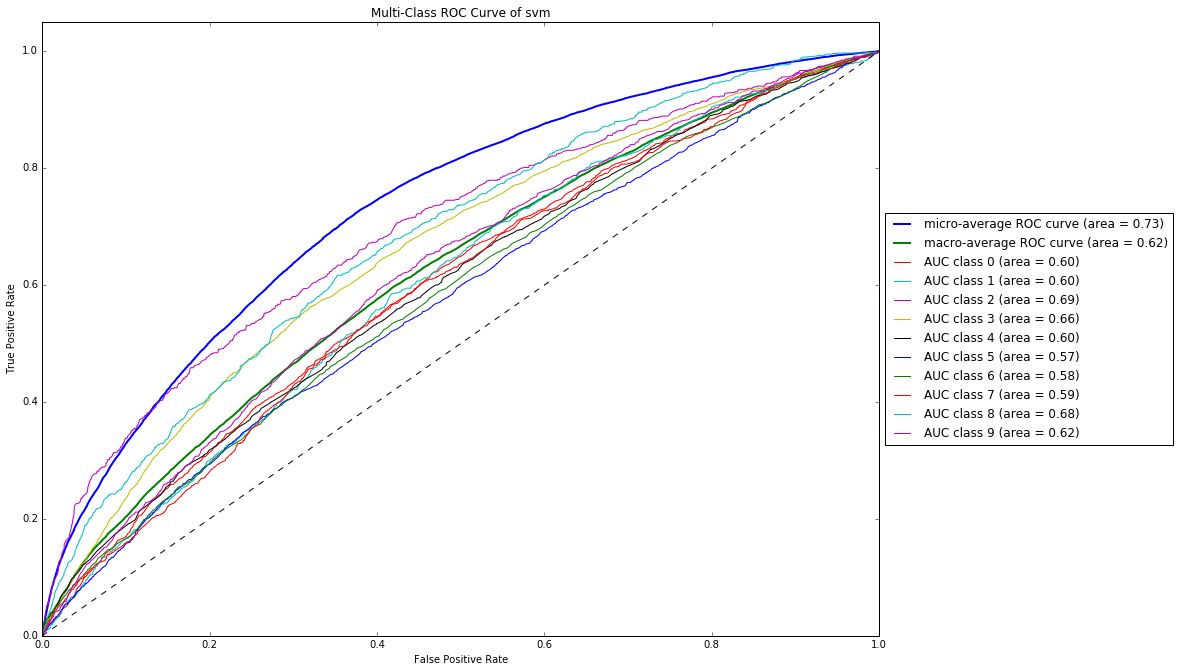

In [122]:
# Running SGD. and RF

svm=SVM(k_fold,train_X,train_Y)
#rf=RF(k_fold,train_X,train_Y)
#lr=Multinomial_Logistic(k_fold,train_X,train_Y)
#gnb=GNB(k_fold,train_X,train_Y)


# ROC Curves
print "ROC Curve for Top 10 category Multi-Class SVM:\n\n"
plot_ROC(test_X,test_Y,svm,"svm")

#print "ROC Curve for Gaussian Naive Bayes:\n\n"
#plot_ROC(test_X,test_Y,gnb,"Gaussian_NB")

#print "ROC Curve for Random Forests:\n\n"
#plot_ROC(test_X,test_Y,rf,"rf")

#print "ROC Curve for Logistic Regression:\n\n"
#plot_ROC(test_X,test_Y,lr,"lr")



i) ***The AUC and Classification can be improved with better Feature Engg. Especially incorporating the features mentioned in the beginning of the post*** 

ii) **Doing a Mullti-class classification of Grouped Categories (Top 10 or so) gives better results than doing it for all 37 categories as not much data is there for each category**

ii) ***Other algorithms were tested on sample data but due to time constraint didn't run on full data, since it was taking time to run on my mac. :(***  


#### There are few more features which could be created. Not doing due to interest of time. Few suggestions : 
1) **Time elapsed between same incident category**   
2) **Grouping Lat/Long to clusters of neighbourhood location instead of directly using the values**  
3) **Creating features out of different Streets mentoned in the address field**  
4) **Week of the month from the timestamp field**  
5) ** Count of crime before the current crime in a crime category**  
6) ** Month of the year**

